# Dogs vs Cats

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
- http://aidiary.hatenablog.com/entry/20170108/1483876657
- http://aidiary.hatenablog.com/entry/20170603/1496493646

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## データ整形

- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
- train.zipとtest.zipをカレントディレクトリにダウンロードしておく

In [4]:
!ls data/

20170104210653.jpg      dancing.jpg             processed/
20170104210658.jpg      hymenoptera_data/       raw/
20170104210705.jpg      hymenoptera_data.zip    test.zip
cifar-10-batches-py/    mnist/                  train.txt
cifar-10-python.tar.gz  picasso.jpg             train.zip


In [27]:
import os
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data', 'dogscats')
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [20]:
!mkdir $data_dir

In [ ]:
!unzip train.zip -d $data_dir

In [ ]:
!unzip test.zip -d $data_dir

In [33]:
!ls -1 $train_dir | wc -l

   25000


In [34]:
!ls -1 $test_dir | wc -l

   12500


訓練データからランダムに選んだ2000画像をvalidationデータとする

In [26]:
!mkdir $valid_dir

In [ ]:
%cd $train_dir

import os
from glob import glob
import numpy as np
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000):
    os.rename(shuf[i], os.path.join(valid_dir, shuf[i]))

In [36]:
!ls -1 $valid_dir | wc -l

    2000


- PyTorchで読み込みやすいようにクラスごとにサブディレクトリを作成する
- Kaggleのテストデータは正解ラベルがついていないため unknown というサブディレクトリにいれる

In [ ]:
# train
%cd $train_dir
%mkdir cats dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
# valid
%cd $valid_dir
%mkdir cats dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [40]:
# test
%cd $test_dir
%mkdir unknown
%mv *.jpg unknown

/Users/koichiro.mori/git/notebooks/pytorch/data/dogscats/test


## VGG16 の出力層のみ置き換える

- 分類層を除いたネットワークのパラメータを固定する
- 分類層のパラメータのみ学習対象

In [ ]:
use_gpu = 

In [41]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()  # eval mode!

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

- 層の置き換え
- 下のように (classifier) の (6) だけを置き換えることはできないみたい 

```
# 最後のfc層のみ2クラス分類できるように置き換える
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)  # <= この代入はできない！
```

- classifierをまるごと置き換える必要がある

In [56]:
# 全層のパラメータを固定
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2)    
)

use_gpu = torch.cuda.is_available()
if use_gpu:
    vgg16 = vgg16.cuda()

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

- VGG用のデータ変換を定義
- 訓練もテストも (224, 224) にサイズ変更のみ
- 正方形の画像でないので `Resize(224)` は動作しない
- 最初はデータ拡張は使わないで試す

In [86]:
train_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## データをロード

In [87]:
train_dataset = datasets.ImageFolder(train_dir, train_preprocess)
valid_dataset = datasets.ImageFolder(valid_dir, test_preprocess)
test_dataset = datasets.ImageFolder(test_dir, test_preprocess)

In [88]:
# DataSetのlenはサンプル数
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

23000
2000
12500


- クラスはアルファベット順？

In [94]:
classes = train_dataset.classes
print(train_dataset.classes)
print(valid_dataset.classes)
print(test_dataset.classes)

['cats', 'dogs']
['cats', 'dogs']
['unknown']


In [90]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128,
                                          shuffle=False)

In [91]:
# DataLoaderのlenはミニバッチ数
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

180
16
98


torch.Size([128, 3, 224, 224]) torch.Size([128])


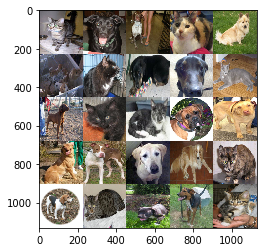

In [106]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

images, classes = next(iter(train_loader))
print(images.size(), classes.size())
images = torchvision.utils.make_grid(images[:25], nrow=5)
imshow(images)